# Modeling - Binary Classification (Gun vs. Not Gun)

In [19]:
import joblib
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from tensorflow.keras.utils import array_to_img, load_img, img_to_array, to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import datetime
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import os, shutil

np.random.seed(42)

In [20]:
# create directions for guns and not guns
data_gun_dir = 'train/gun'
data_not_gun_dir = 'train/not_gun/'

# new directory for the train test validation split
new_dir = './HCsplit/'

In [21]:
# add gun images 
imgs_gun = [file for file in os.listdir(new_dir+data_gun_dir) if file.endswith('.jpg')]

In [22]:
# check first ten 
imgs_gun[0:10]

['001_0001.jpg',
 '001_0002 (2).jpg',
 '001_0009.jpg',
 '001_0014.jpg',
 '001_0019.jpg',
 '001_0020.jpg',
 '001_0021.jpg',
 '001_0022 - copia.jpg',
 '001_0022.jpg',
 '001_0023.jpg']

In [23]:
len(imgs_gun)

2392

In [24]:
# add not gun images
imgs_not_gun = [file for file in os.listdir(new_dir+data_not_gun_dir) if file.endswith('.jpg')]

In [25]:
imgs_not_gun[0:10]

['-10.jpg',
 '-108.jpg',
 '-109.jpg',
 '-11.jpg',
 '-118.jpg',
 '-119.jpg',
 '-12.jpg',
 '-120.jpg',
 '-121.jpg',
 '-122.jpg']

In [26]:
len(imgs_not_gun)

1290

In [27]:
#new_dir = './HCsplit/'

In [28]:
# below code creates new directory if not already created
#os.mkdir(new_dir)

In [29]:
# from the new directory, create new training, test, and val folders to store the guns and not guns
train_folder = os.path.join(new_dir, 'train')
train_gun = os.path.join(train_folder, 'gun')
train_not_gun = os.path.join(train_folder, 'not_gun')

test_folder = os.path.join(new_dir, 'test')
test_gun = os.path.join(test_folder, 'gun')
test_not_gun = os.path.join(test_folder, 'not_gun')

val_folder = os.path.join(new_dir, 'validation')
val_gun = os.path.join(val_folder, 'gun')
val_not_gun = os.path.join(val_folder, 'not_gun')

In [30]:
# os.mkdir(test_folder)
# os.mkdir(test_gun)
# os.mkdir(test_not_gun)

# os.mkdir(train_folder)
# os.mkdir(train_gun)
# os.mkdir(train_not_gun)

# os.mkdir(val_folder)
# os.mkdir(val_gun)
# os.mkdir(val_not_gun)

Now we will slice the images from `imgs_not_gun` into train, validation, and test folders and do the same for `imgs_gun` into train, validation, and test folders.

**Not Gun Images**

**Gun Images**

Check how many images are in each set.

In [31]:
print('There are', len(os.listdir(train_gun)), 'gun images in the train set')
print('There are', len(os.listdir(val_gun)), 'gun images in the validation set')
print('There are', len(os.listdir(test_gun)), 'gun images in the test set')

There are 2392 gun images in the train set
There are 896 gun images in the validation set
There are 940 gun images in the test set


In [32]:
print('There are', len(os.listdir(train_not_gun)), 'not gun images in the train set')
print('There are', len(os.listdir(val_not_gun)), 'not gun images in the validation set')
print('There are', len(os.listdir(test_not_gun)), 'not gun images in the test set')

There are 1290 not gun images in the train set
There are 437 not gun images in the validation set
There are 450 not gun images in the test set


## Preprocessing Images 

- Normalize
- Set up image size
- Set up size of training, validation, and test sets

In [33]:
# get all the data in the directory split/train, and reshape them
# normalizees by rescaling
# set image size to 256 x 256
# batch size varies for each set size

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     train_folder, 
                                                     target_size=(224, 224),
                                                     classes = ['not_gun', 'gun'],
                                                     batch_size=3000) # 3682 total from train

# get all the data in the directory split/validation, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                   val_folder, 
                                                   target_size=(224, 224),
                                                   classes = ['not_gun', 'gun'],
                                                   batch_size = 1000) # 1333 total from val

# get all the data in the directory split/test, and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    test_folder, 
                                                    target_size=(224, 224),
                                                    classes = ['not_gun', 'gun'],
                                                    batch_size = 1000) # 1390 total from test

Found 3682 images belonging to 2 classes.
Found 1333 images belonging to 2 classes.
Found 1390 images belonging to 2 classes.


In [34]:
# create the data sets and label the images as gun or not gun
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [35]:
# check shape of images in train set
train_images.shape

(3000, 224, 224, 3)

In [36]:
# check labels for train
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [37]:
train_generator.class_indices

{'not_gun': 0, 'gun': 1}

Label: [1. 0.]


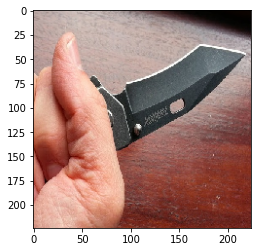

In [38]:
# check an example gun image
sample_train_image = train_images[105]
sample_train_label = train_labels[105]
display(plt.imshow(sample_train_image))
print('Label: {}'.format(sample_train_label))

Label: [0. 1.]


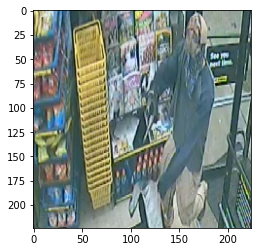

In [39]:
# check an example not gun image
sample_train_image = train_images[0]
sample_train_label = train_labels[0]
display(plt.imshow(sample_train_image))
print('Label: {}'.format(sample_train_label))

### Visualize the Image Dataset

In [40]:
# function that plots images and labels
def plots(ims, figsize = (20,4), rows = 1, interp = False, titles = None):
    """
    Takes in image set (recommend to slice for large sets); and image labels
    and plots a row of the images with associated labels.
    """
    if type(ims[0]) is np.ndarray:
        ims - np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims - ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 -- 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i +1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

C:\Users\eggfr\anaconda3\envs\tensor_flow\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


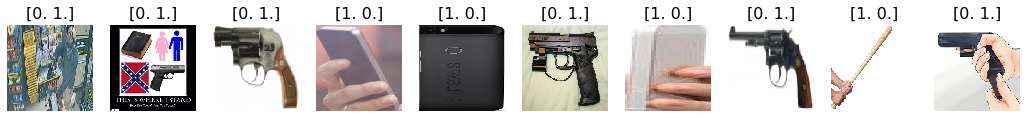

In [41]:
# peek at 10 images in the train set
plots(train_images[0:10], titles = train_labels[0:10])

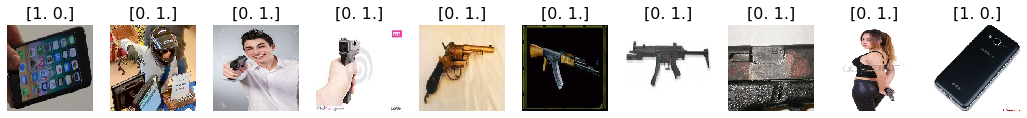

In [42]:
# peek at 10 images in the test set
plots(test_images[500:510], titles = test_labels[500:510])

In [43]:
# Explore dataset again
m_train = train_images.shape[0]  # number of images in train
num_px = train_images.shape[1]  # number of pixels
m_test = test_images.shape[0]  # number of images in test
m_val = val_images.shape[0]  # number of images in validation 

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print('-'*40)
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print('-'*40)
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print('-'*40)
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 3000
Number of testing samples: 1000
Number of validation samples: 1000
----------------------------------------
train_images shape: (3000, 224, 224, 3)
train_labels shape: (3000, 2)
----------------------------------------
test_images shape: (1000, 224, 224, 3)
test_labels shape: (1000, 2)
----------------------------------------
val_images shape: (1000, 224, 224, 3)
val_labels shape: (1000, 2)


### Reshaping the images

In [44]:
# reshapes the images to (num of images in set, num of pixels ie. 64 x 64 x 3 = 12288)
train_img = train_images.reshape(train_images.shape[0], -1) 
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print("Train", train_img.shape)
print("Validation", val_img.shape)
print("Test", test_img.shape)

Train (3000, 150528)
Validation (1000, 150528)
Test (1000, 150528)


Lets check the class balance for each image set:

In [45]:
# check train labels shape; currently as a binary tuple label
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [46]:
# get array of not gun vs. gun image labels
train_label_sum = sum(train_labels)
val_label_sum = sum(val_labels)
test_label_sum = sum(test_labels)

# get percentage of gun images in each set
train_gun_balance = round(train_label_sum[1] / len(train_labels),3)
val_gun_balance = round(val_label_sum[1] / len(val_labels),3)
test_gun_balance = round(test_label_sum[1] / len(test_labels),3)

print("Percentage of Gun Images in Train Set:", train_gun_balance)
print("Percentage of Gun Images in Validation Set:", val_gun_balance)
print("Percentage of Gun Images in Test Set:", test_gun_balance)


Percentage of Gun Images in Train Set: 0.647
Percentage of Gun Images in Validation Set: 0.667
Percentage of Gun Images in Test Set: 0.671


Finally, to model, we need to reshape the target variable so that it is in the correct shape.

In [47]:
# reshape the target, changes target values to binary (1 or 0)
train_y = np.reshape(train_labels[:,1], (3000,1))
test_y = np.reshape(test_labels[:,1], (1000,1))
val_y = np.reshape(val_labels[:,1], (1000,1))

In [48]:
# check test_y 
test_y[0:15]

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.]], dtype=float32)

In [49]:
# verify test_y labels are correct with test set
test_labels[0:15]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [50]:
# check change
print(train_y)
print(train_y.shape)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]
(3000, 1)


## Build Baseline Dense Network

In [86]:
# Build a baseline fully connected model
np.random.seed(42)

baseline_model = models.Sequential()
baseline_model._name = "Baseline" # names the model

baseline_model.add(layers.Dense(64, activation='relu', input_shape=(150528,))) 

# 2 hidden layers
baseline_model.add(layers.Dense(32, activation='relu'))
baseline_model.add(layers.Dense(16, activation='relu'))

baseline_model.add(layers.Dense(1, activation='sigmoid')) 

In [87]:
baseline_model.summary()

Model: "Baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                9633856   
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 9,636,481
Trainable params: 9,636,481
Non-trainable params: 0
_________________________________________________________________


In [58]:
# terminate training if doesnt improve on specified min_delta for 5 epochs
trainCallback = EarlyStopping(monitor='accuracy', min_delta = 1e-2, patience = 5)

**⏰ Below code runs for a few minutes**

In [88]:
baseline_model.compile(optimizer='adam',
              loss='binary_crossentropy', # for binary classification (gun or not gun)
              metrics=['accuracy'])

baseline_model = baseline_model.fit(train_img,
                                    train_y,
                                    epochs=50,
                                    batch_size=64,
                                    validation_data=(val_img, val_y),
                                    callbacks=[trainCallback])

Epoch 1/50
47/47 [==============================] - 8s 101ms/step - loss: 2.5957 - accuracy: 0.6140 - val_loss: 1.3641 - val_accuracy: 0.6830
Epoch 2/50
47/47 [==============================] - 4s 87ms/step - loss: 1.7391 - accuracy: 0.6467 - val_loss: 0.9728 - val_accuracy: 0.7010
Epoch 3/50
47/47 [==============================] - 4s 80ms/step - loss: 1.2453 - accuracy: 0.6607 - val_loss: 0.7234 - val_accuracy: 0.7270
Epoch 4/50
47/47 [==============================] - 4s 80ms/step - loss: 0.7918 - accuracy: 0.7090 - val_loss: 0.5931 - val_accuracy: 0.7360
Epoch 5/50
47/47 [==============================] - 4s 77ms/step - loss: 2.0507 - accuracy: 0.6353 - val_loss: 1.7955 - val_accuracy: 0.5510
Epoch 6/50
47/47 [==============================] - 3s 74ms/step - loss: 0.9306 - accuracy: 0.7000 - val_loss: 0.7321 - val_accuracy: 0.6860
Epoch 7/50
47/47 [==============================] - 4s 82ms/step - loss: 0.7720 - accuracy: 0.7153 - val_loss: 0.5966 - val_accuracy: 0.7150
Epoch 8/50
4

## Save the model as a .pkl file

Unfortunately- I wasnt not be able to save the model as a pickle file.

In [193]:
#import tempfile
#from tensorflow.keras.models import Sequential, load_model, save_model, Model

In [194]:
#def make_keras_picklable():
#    def __getstate__(self):
#        model_str = ""
#        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
#            save_model(self, fd.name, overwrite=True)
#            model_str = fd.read()
#        d = {'model_str': model_str}
#        return d

#    def __setstate__(self, state):
#        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
#            fd.write(state['model_str'])
#            fd.flush()
#            model = load_model(fd.name)
#        self.__dict__ = model.__dict__


#    cls = Model
#    cls.__getstate__ = __getstate__
#    cls.__setstate__ = __setstate__

In [195]:
#make_keras_picklable()

In [1]:
# # use the built-in open() function to open a file
#output_file = open("baseline_model.pkl", "wb") # "wb" means "write as bytes"

# dump the variable's contents into the file
#joblib.dump(baseline_model, output_file)

# # close the file, ensuring nothing stays in the buffer
#output_file.close()

In [ ]:
# use the built-in open() function again, this time to read
#model_file = open("baseline_model.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
#loaded_baseline_model = joblib.load(model_file)
# close the file
#model_file.close()

In [89]:
# create a helper function that returns loss and accuracy results from model
# also plots the loss and accuracy 

def model_results(mod, train_img, train_y, test_img, test_y):
    """ Takes in the model, image set, and array y of targets for training and test sets
        and returns the model's loss and accuracy scores.
        Also returns a plot of the training and validation scores. 
    """
    # returns loss and accuracy scores for training and test sets
    results_train = mod.model.evaluate(train_img, train_y)
    results_test = mod.model.evaluate(test_img, test_y)
    
    # get the accuracy and loss for training and validation
    acc = mod.history['accuracy']
    val_acc = mod.history['val_accuracy']
    loss = mod.history['loss']
    val_loss = mod.history['val_loss']
    epochs = range(len(acc))
    
    # return train and test loss and accuracy
    print("Train Results Loss:", round(results_train[0],5))
    print("Train Results Accuracy:", round(results_train[1], 5))
    print("-"* 50)
    print("Test Results Loss:", round(results_test[0],5))
    print("Test Results Accuracy:", round(results_test[1], 5))
    
    # plot the Traininng and Validation Accuracy and Loss
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and Validation accuracy', fontweight = "bold")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and Validation loss', fontweight = "bold")
    plt.legend()
    plt.show()

### Baseline Model Results

32/32 [==============================] - 0s 13ms/step - loss: 0.8726 - accuracy: 0.6480
Train Results Loss: 0.69028
Train Results Accuracy: 0.69
--------------------------------------------------
Test Results Loss: 0.87264
Test Results Accuracy: 0.648


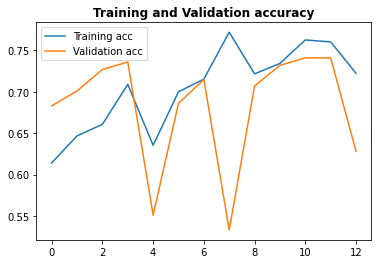

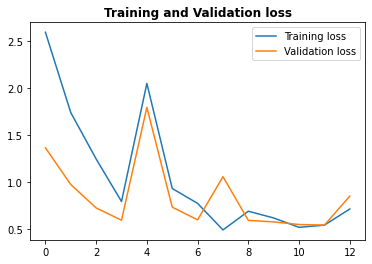

In [90]:
# get baseline model results
model_results(baseline_model, train_img, train_y, test_img, test_y)

In [91]:
# create helper function to plot test results as a confusion matrix
def get_test_results(mod, test_img, test_y):
    """
    Takes in the model, test image set, and test_y set
    and returns the model's accuracy and confusion matrix.
    """
    # return the loss and accuracy scores for the test set
    mod.model.evaluate(test_img, test_y)
    
    # get probabilites from the prediction on the test image set
    y_proba = mod.model.predict(test_img)
    
    # get assigned index values; ie. predicted labels
    predicted = y_proba.round()

    # plot confusion matrix on test set
    cm = confusion_matrix(test_y, predicted)

    disp = ConfusionMatrixDisplay(
        display_labels = ['Not Gun', 'Gun'],
        confusion_matrix=cm)

    disp.plot(cmap=plt.cm.Blues)
    
    model_name = mod.model.name

    # labels, title and ticks

    plt.title(model_name + "\nGun & Not Gun Binary Classification Matrix")
    plt.show()
    

32/32 [==============================] - 1s 28ms/step - loss: 0.8726 - accuracy: 0.6480


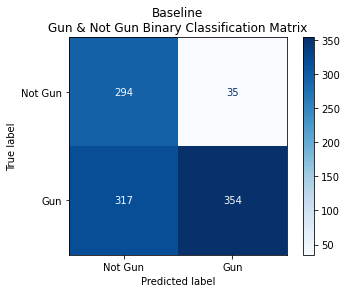

In [92]:
# get confusion matrix and test results for test image set
get_test_results(baseline_model, test_img, test_y)

## Building a CNN

In [93]:
cnn_model = models.Sequential()
cnn_model._name = "CNN"

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [94]:
cnn_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 108, 108, 32)      16416     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 43264)             0       

**⏰ Below code runs for about 8 minutes**

In [95]:
# create a CNN model
cnn_model = cnn_model.fit(train_images,
                            train_y,
                            epochs=20,
                            batch_size=64,
                            validation_data=(val_images, val_y),
                            callbacks=[trainCallback])

Epoch 1/20
47/47 [==============================] - 69s 1s/step - loss: 0.6328 - accuracy: 0.6410 - val_loss: 0.6285 - val_accuracy: 0.6510
Epoch 2/20
47/47 [==============================] - 61s 1s/step - loss: 0.6031 - accuracy: 0.6480 - val_loss: 0.5766 - val_accuracy: 0.6540
Epoch 3/20
47/47 [==============================] - 74s 2s/step - loss: 0.5852 - accuracy: 0.6737 - val_loss: 0.5832 - val_accuracy: 0.7100
Epoch 4/20
47/47 [==============================] - 73s 2s/step - loss: 0.5660 - accuracy: 0.6827 - val_loss: 0.5455 - val_accuracy: 0.7300
Epoch 5/20
47/47 [==============================] - 64s 1s/step - loss: 0.5435 - accuracy: 0.7103 - val_loss: 0.5087 - val_accuracy: 0.7150
Epoch 6/20
47/47 [==============================] - 61s 1s/step - loss: 0.5048 - accuracy: 0.7363 - val_loss: 0.4862 - val_accuracy: 0.7380
Epoch 7/20
47/47 [==============================] - 65s 1s/step - loss: 0.4933 - accuracy: 0.7500 - val_loss: 0.4642 - val_accuracy: 0.7580
Epoch 8/20
47/47 [==

In [ ]:
# # use the built-in open() function to open a file
# output_file = open("cnn_model.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(cnn_model, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

In [2]:
# use the built-in open() function again, this time to read
#cnn_model_file = open("cnn_model.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
#loaded_cnn_model = joblib.load(cnn_model_file)
# close the file
#cnn_model_file.close()

32/32 [==============================] - 14s 373ms/step - loss: 0.4985 - accuracy: 0.8050
Train Results Loss: 0.37415
Train Results Accuracy: 0.81767
--------------------------------------------------
Test Results Loss: 0.49852
Test Results Accuracy: 0.805


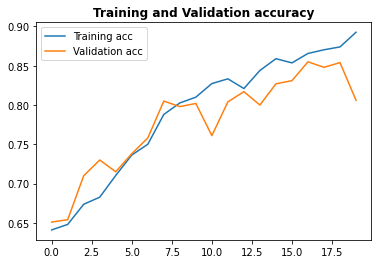

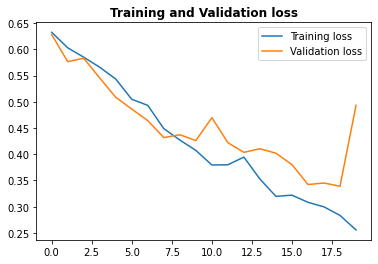

In [96]:
# get baseline model results
model_results(cnn_model, train_images, train_y, test_images, test_y)

32/32 [==============================] - 5s 159ms/step - loss: 0.4985 - accuracy: 0.8050


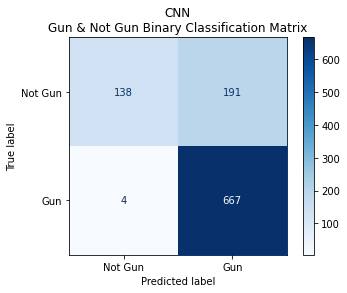

In [97]:
# get confusion matrix and test results for test image set
get_test_results(cnn_model, test_images, test_y)

Accuracy is ay 80% for the baseline, and precision is at 98%. While we have a really good precision score, accuracy need improvement as there is too many false positive. Also, baseline model do overfit

In [76]:
from keras import regularizers

CNN model 2

Previous CNN model was a bit overfitting, so I decide to add a regulazier and a drop out layer.

In [88]:
cnn_model_2 = models.Sequential()
cnn_model_2._name = "CNN2Dropout"   #add a dropout layer

cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))

cnn_model_2.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Dropout(0.3))   #add a dropout layer

cnn_model_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))

cnn_model_2.add(layers.Flatten())
cnn_model_2.add(layers.Dense(64, activation='relu'))
cnn_model_2.add(layers.Dense(1, activation='sigmoid'))

cnn_model_2.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [89]:
cnn_model_2.summary()

Model: "CNN2Dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 108, 108, 32)      16416     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 26, 26, 64)        

In [91]:
# create a CNN model
cnn_model_2 = cnn_model_2.fit(train_images,
                            train_y,
                            epochs=20,
                            batch_size=64,
                            validation_data=(val_images, val_y),
                            callbacks=[trainCallback])

Epoch 1/20
47/47 [==============================] - 100s 2s/step - loss: 1.1736 - accuracy: 0.6443 - val_loss: 0.8179 - val_accuracy: 0.7070
Epoch 2/20
47/47 [==============================] - 81s 2s/step - loss: 0.7278 - accuracy: 0.7390 - val_loss: 0.6346 - val_accuracy: 0.7640
Epoch 3/20
47/47 [==============================] - 79s 2s/step - loss: 0.5643 - accuracy: 0.8230 - val_loss: 0.5727 - val_accuracy: 0.8110
Epoch 4/20
47/47 [==============================] - 78s 2s/step - loss: 0.5234 - accuracy: 0.8287 - val_loss: 0.6042 - val_accuracy: 0.7950
Epoch 5/20
47/47 [==============================] - 79s 2s/step - loss: 0.4757 - accuracy: 0.8427 - val_loss: 0.5368 - val_accuracy: 0.8200
Epoch 6/20
47/47 [==============================] - 78s 2s/step - loss: 0.3966 - accuracy: 0.8733 - val_loss: 0.4361 - val_accuracy: 0.8660
Epoch 7/20
47/47 [==============================] - 78s 2s/step - loss: 0.3514 - accuracy: 0.8870 - val_loss: 0.4296 - val_accuracy: 0.8670
Epoch 8/20
47/47 [=

32/32 [==============================] - 19s 533ms/step - loss: 0.5230 - accuracy: 0.8810
Train Results Loss: 0.04967
Train Results Accuracy: 0.99733
--------------------------------------------------
Test Results Loss: 0.52298
Test Results Accuracy: 0.881


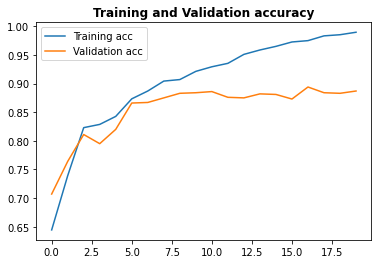

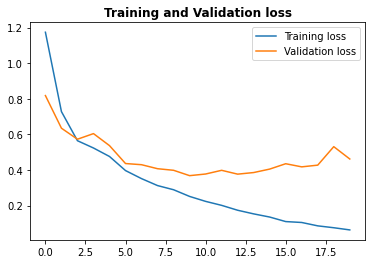

In [92]:
model_results(cnn_model_2, train_images, train_y, test_images, test_y)

32/32 [==============================] - 6s 188ms/step - loss: 0.5230 - accuracy: 0.8810


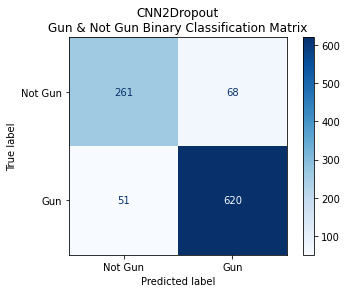

In [93]:
get_test_results(cnn_model_2, test_images, test_y)

The Regualzier reduces the overfitting by a little bit- The test result still has a 88% accuracy and a 92% recall.

In [54]:
from tensorflow.keras import regularizers

CNN model 3. I would like to see if adding one extra layer would increase our precision and accuracy score

In [59]:
cnn_model_3 = models.Sequential()
cnn_model._name = "CNN3add1layernDropout"

cnn_model_3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))
cnn_model_3.add(layers.Dropout(0.3))

cnn_model_3.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))
cnn_model_3.add(layers.Dropout(0.3))


cnn_model_3.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Flatten())
cnn_model_3.add(layers.Dense(64, activation='relu'))
cnn_model_3.add(layers.Dense(1, activation='sigmoid'))

cnn_model_3.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [61]:
cnn_model_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 108, 108, 32)      16416     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 51, 51, 32)        16416     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 32)       

In [62]:
cnn_model_3 = cnn_model_3.fit(train_images,
                            train_y,
                            epochs=20,
                            batch_size=64,
                            validation_data=(val_images, val_y),
                            callbacks=[trainCallback])

Epoch 1/20
47/47 [==============================] - 98s 2s/step - loss: 1.0093 - accuracy: 0.6080 - val_loss: 0.8591 - val_accuracy: 0.6670
Epoch 2/20
47/47 [==============================] - 80s 2s/step - loss: 0.7812 - accuracy: 0.6470 - val_loss: 0.7079 - val_accuracy: 0.6670
Epoch 3/20
47/47 [==============================] - 82s 2s/step - loss: 0.6524 - accuracy: 0.6767 - val_loss: 0.6034 - val_accuracy: 0.7120
Epoch 4/20
47/47 [==============================] - 78s 2s/step - loss: 0.5817 - accuracy: 0.7307 - val_loss: 0.5421 - val_accuracy: 0.7490
Epoch 5/20
47/47 [==============================] - 80s 2s/step - loss: 0.5076 - accuracy: 0.7797 - val_loss: 0.4799 - val_accuracy: 0.8010
Epoch 6/20
47/47 [==============================] - 78s 2s/step - loss: 0.4398 - accuracy: 0.8157 - val_loss: 0.4495 - val_accuracy: 0.8220
Epoch 7/20
47/47 [==============================] - 79s 2s/step - loss: 0.3995 - accuracy: 0.8330 - val_loss: 0.4084 - val_accuracy: 0.8330
Epoch 8/20
47/47 [==

32/32 [==============================] - 34s 798ms/step - loss: 0.3338 - accuracy: 0.8920
Train Results Loss: 0.10188
Train Results Accuracy: 0.97667
--------------------------------------------------
Test Results Loss: 0.33379
Test Results Accuracy: 0.892


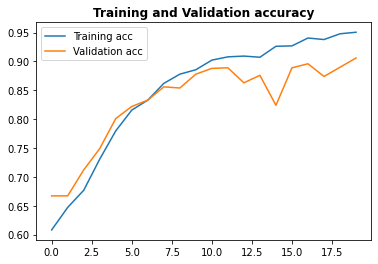

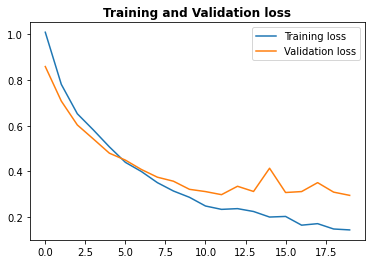

In [63]:
model_results(cnn_model_3, train_images, train_y, test_images, test_y)

32/32 [==============================] - 5s 151ms/step - loss: 0.3338 - accuracy: 0.8920


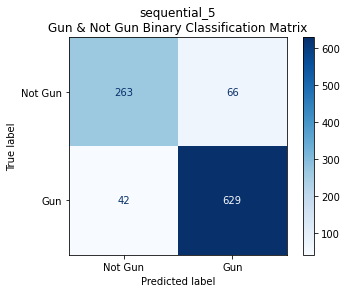

In [64]:
get_test_results(cnn_model_3, test_images, test_y)

By adding 1 layer- the accuracy increases from 88% to 89% and the precision score increase from 92% to 93.5%. This is so far the best model as it has the highest accuracy and precision score while overfitting seems to be reduced.

Model 4- Layers adjustment.

This model is the same as 
model 2 but adjustment is to start w small filters at the beginning and big filters at the end to see if there is any impact to have w a bigger shape/dimension at the beginning and tighten it at the end.

In [79]:
cnn_model_4 = models.Sequential()
cnn_model_4._name = "CNNincreaselayers"

cnn_model_4.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
cnn_model_4.add(layers.MaxPooling2D((2, 2)))
cnn_model_4.add(layers.Dropout(0.3))

cnn_model_4.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model_4.add(layers.MaxPooling2D((2, 2)))
cnn_model_4.add(layers.Dropout(0.3))

cnn_model_4.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model_4.add(layers.MaxPooling2D((2, 2)))


cnn_model_4.add(layers.Flatten())
cnn_model_4.add(layers.Dense(64, activation='relu'))
cnn_model_4.add(layers.Dense(1, activation='sigmoid'))

cnn_model_4.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [80]:
cnn_model_4.summary()

Model: "CNNincreaselayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 108, 108, 32)      8224      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 52, 52, 64)  

In [66]:
cnn_model_4 = cnn_model_4.fit(train_images,
                            train_y,
                            epochs=20,
                            batch_size=64,
                            validation_data=(val_images, val_y),
                            callbacks=[trainCallback])

Epoch 1/20
47/47 [==============================] - 56s 1s/step - loss: 1.1200 - accuracy: 0.6400 - val_loss: 0.9246 - val_accuracy: 0.6670
Epoch 2/20
47/47 [==============================] - 57s 1s/step - loss: 0.8401 - accuracy: 0.6470 - val_loss: 0.7576 - val_accuracy: 0.6670
Epoch 3/20
47/47 [==============================] - 59s 1s/step - loss: 0.7065 - accuracy: 0.7017 - val_loss: 0.6755 - val_accuracy: 0.7240
Epoch 4/20
47/47 [==============================] - 57s 1s/step - loss: 0.6194 - accuracy: 0.7600 - val_loss: 0.5847 - val_accuracy: 0.7600
Epoch 5/20
47/47 [==============================] - 56s 1s/step - loss: 0.5359 - accuracy: 0.8157 - val_loss: 0.5385 - val_accuracy: 0.8190
Epoch 6/20
47/47 [==============================] - 56s 1s/step - loss: 0.4619 - accuracy: 0.8350 - val_loss: 0.4584 - val_accuracy: 0.8310
Epoch 7/20
47/47 [==============================] - 56s 1s/step - loss: 0.3813 - accuracy: 0.8683 - val_loss: 0.4586 - val_accuracy: 0.8380
Epoch 8/20
47/47 [==

In [81]:
cnn_model_4 = cnn_model_4.fit(train_images,
                            train_y,
                            epochs=20,
                            batch_size=64,
                            validation_data=(val_images, val_y),
                            callbacks=[trainCallback])

Epoch 1/20
47/47 [==============================] - 73s 2s/step - loss: 1.5663 - accuracy: 0.6010 - val_loss: 0.9669 - val_accuracy: 0.6670
Epoch 2/20
47/47 [==============================] - 53s 1s/step - loss: 0.8823 - accuracy: 0.6470 - val_loss: 0.8071 - val_accuracy: 0.6670
Epoch 3/20
47/47 [==============================] - 46s 987ms/step - loss: 0.7693 - accuracy: 0.6470 - val_loss: 0.7404 - val_accuracy: 0.6670
Epoch 4/20
47/47 [==============================] - 47s 1s/step - loss: 0.6998 - accuracy: 0.6470 - val_loss: 0.7229 - val_accuracy: 0.6670
Epoch 5/20
47/47 [==============================] - 45s 952ms/step - loss: 0.6583 - accuracy: 0.7327 - val_loss: 0.6968 - val_accuracy: 0.7550
Epoch 6/20
47/47 [==============================] - 43s 924ms/step - loss: 0.6253 - accuracy: 0.7657 - val_loss: 0.6207 - val_accuracy: 0.8060
Epoch 7/20
47/47 [==============================] - 44s 935ms/step - loss: 0.5775 - accuracy: 0.7977 - val_loss: 0.5804 - val_accuracy: 0.7990
Epoch 8/

32/32 [==============================] - 11s 274ms/step - loss: 0.4849 - accuracy: 0.8510
Train Results Loss: 0.27811
Train Results Accuracy: 0.92833
--------------------------------------------------
Test Results Loss: 0.48493
Test Results Accuracy: 0.851


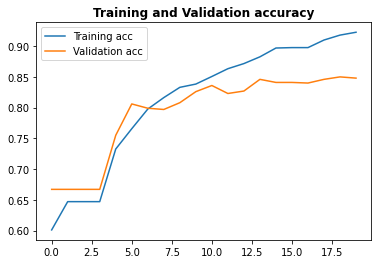

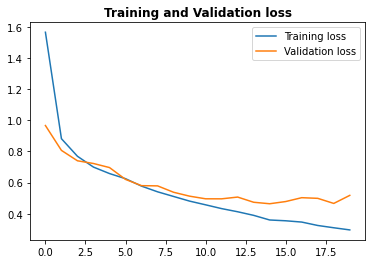

In [82]:
model_results(cnn_model_4, train_images, train_y, test_images, test_y)

32/32 [==============================] - 5s 162ms/step - loss: 0.4849 - accuracy: 0.8510


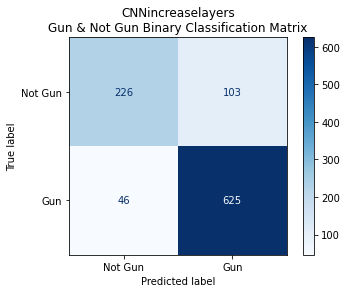

In [110]:
get_test_results(cnn_model_4, test_images, test_y)

The accuracy score reduces to 85% and the precision score remains at 93.5%. Overfitting looks a bit better than model 3 but the accuracy reduces.

Model_5: We just add another layer and also adjust the strides to 2 to see if we can get a better accracy and precision score

In [63]:
cnn_model_5 = models.Sequential()
cnn_model_5._name = "CNN5"   #add a dropout layer

cnn_model_5.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
cnn_model_5.add(layers.MaxPooling2D((2, 2)))

cnn_model_5.add(layers.Conv2D(32, (4, 4), activation='relu')) #s
cnn_model_5.add(layers.MaxPooling2D((2, 2)))
cnn_model_5.add(layers.Dropout(0.3))   #add a dropout layer

cnn_model_5.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model_5.add(layers.MaxPooling2D((2, 2)))

cnn_model_5.add(layers.Conv2D(128, (3, 3), strides = (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.01))) # add a 128 layer w padding (1,1),  and regulaizer
cnn_model_5.add(layers.MaxPooling2D((2, 2)))

cnn_model_5.add(layers.Flatten())
cnn_model_5.add(layers.Dense(128, activation='relu'))
cnn_model_5.add(layers.Dense(1, activation='sigmoid'))

cnn_model_5.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [64]:
cnn_model_5.summary()

Model: "CNN5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 108, 108, 32)      16416     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 26, 26, 64)        0      

In [65]:
cnn_model_5 = cnn_model_5.fit(train_images,
                            train_y,
                            epochs=20,
                            batch_size=64,
                            validation_data=(val_images, val_y),
                            callbacks=[trainCallback])

Epoch 1/20
47/47 [==============================] - 70s 1s/step - loss: 1.2667 - accuracy: 0.6483 - val_loss: 0.8174 - val_accuracy: 0.6780
Epoch 2/20
47/47 [==============================] - 68s 1s/step - loss: 0.6524 - accuracy: 0.7183 - val_loss: 0.5876 - val_accuracy: 0.7550
Epoch 3/20
47/47 [==============================] - 66s 1s/step - loss: 0.5178 - accuracy: 0.7823 - val_loss: 0.4716 - val_accuracy: 0.8170
Epoch 4/20
47/47 [==============================] - 70s 1s/step - loss: 0.4519 - accuracy: 0.8120 - val_loss: 0.4530 - val_accuracy: 0.8160
Epoch 5/20
47/47 [==============================] - 78s 2s/step - loss: 0.4016 - accuracy: 0.8470 - val_loss: 0.4270 - val_accuracy: 0.8440
Epoch 6/20
47/47 [==============================] - 62s 1s/step - loss: 0.3675 - accuracy: 0.8613 - val_loss: 0.4161 - val_accuracy: 0.8490
Epoch 7/20
47/47 [==============================] - 62s 1s/step - loss: 0.3367 - accuracy: 0.8720 - val_loss: 0.3804 - val_accuracy: 0.8700
Epoch 8/20
47/47 [==

32/32 [==============================] - 7s 201ms/step - loss: 0.4774 - accuracy: 0.8840
Train Results Loss: 0.08676
Train Results Accuracy: 0.993
--------------------------------------------------
Test Results Loss: 0.47739
Test Results Accuracy: 0.884


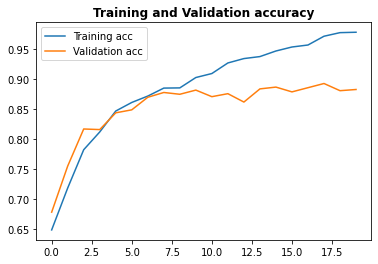

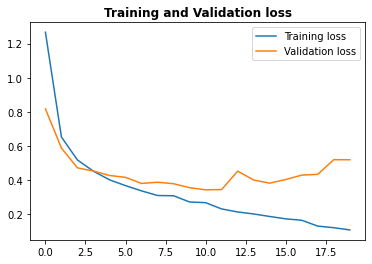

In [66]:
model_results(cnn_model_5, train_images, train_y, test_images, test_y)

32/32 [==============================] - 6s 195ms/step - loss: 0.4774 - accuracy: 0.88401s - loss: 0.4728 - accuracy:  - ETA: 1s - loss: 0.5137 - 


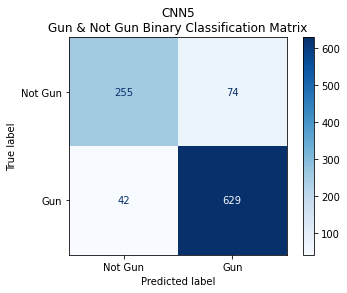

In [107]:
get_test_results(cnn_model_5, test_images, test_y)
    

Accuracy remains at 88% and it started to overfit. Hence, adding layer doesnt improve the accuracy but create the overfit issue. Precision also remains at 93.5%.

CNN model 6- This is the same model as model 2 and we just make the changes on MaxPooling to (3x3)

In [102]:
cnn_model_6 = models.Sequential()
cnn_model_6._name = "CNN2MaxPool3x3"   #add a dropout layer

cnn_model_6.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
cnn_model_6.add(layers.MaxPooling2D((3, 3)))

cnn_model_6.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_6.add(layers.MaxPooling2D((3, 3)))
cnn_model_6.add(layers.Dropout(0.3))   #add a dropout layer

cnn_model_6.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model_6.add(layers.MaxPooling2D((3, 3)))

cnn_model_6.add(layers.Flatten())
cnn_model_6.add(layers.Dense(64, activation='relu'))
cnn_model_6.add(layers.Dense(1, activation='sigmoid'))

cnn_model_6.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [103]:
cnn_model_6.summary()

Model: "CNN2Dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 71, 71, 32)        16416     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 7, 7, 64)          

In [104]:
cnn_model_6 = cnn_model_6.fit(train_images,
                            train_y,
                            epochs=20,
                            batch_size=64,
                            validation_data=(val_images, val_y),
                            callbacks=[trainCallback])

Epoch 1/20
47/47 [==============================] - 53s 1s/step - loss: 0.9219 - accuracy: 0.6260 - val_loss: 0.7471 - val_accuracy: 0.6720
Epoch 2/20
47/47 [==============================] - 50s 1s/step - loss: 0.6494 - accuracy: 0.7257 - val_loss: 0.5681 - val_accuracy: 0.7510
Epoch 3/20
47/47 [==============================] - 40s 857ms/step - loss: 0.5515 - accuracy: 0.7583 - val_loss: 0.4981 - val_accuracy: 0.7880
Epoch 4/20
47/47 [==============================] - 40s 862ms/step - loss: 0.4710 - accuracy: 0.8060 - val_loss: 0.4375 - val_accuracy: 0.8270
Epoch 5/20
47/47 [==============================] - 40s 861ms/step - loss: 0.4119 - accuracy: 0.8443 - val_loss: 0.3914 - val_accuracy: 0.8530
Epoch 6/20
47/47 [==============================] - 39s 842ms/step - loss: 0.3607 - accuracy: 0.8647 - val_loss: 0.3950 - val_accuracy: 0.8520
Epoch 7/20
47/47 [==============================] - 40s 858ms/step - loss: 0.3467 - accuracy: 0.8730 - val_loss: 0.3444 - val_accuracy: 0.8730
Epoch

32/32 [==============================] - 18s 452ms/step - loss: 0.2860 - accuracy: 0.9090s - loss: 0.2829 - accuracy: 
Train Results Loss: 0.1537
Train Results Accuracy: 0.957
--------------------------------------------------
Test Results Loss: 0.28595
Test Results Accuracy: 0.909


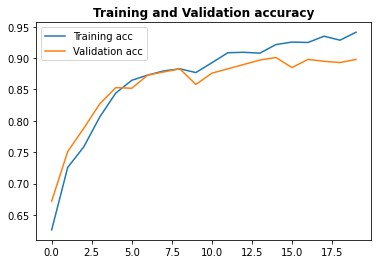

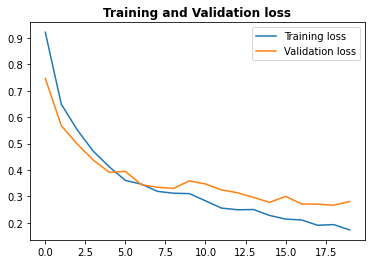

In [105]:
model_results(cnn_model_6, train_images, train_y, test_images, test_y)

32/32 [==============================] - 4s 116ms/step - loss: 0.2860 - accuracy: 0.9090


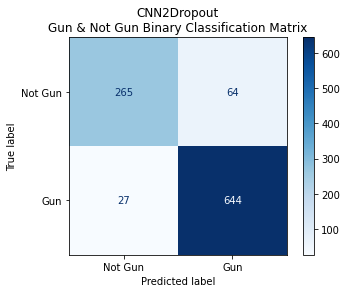

In [108]:
get_test_results(cnn_model_6, test_images, test_y)

This is by far the best model performance with a 90% accuracy score and and a precision of 95.5.

CNN- 7- We modify the MaxPool dimension with a (3x3) dimension with model 3.

In [112]:
cnn_model_7 = models.Sequential()
cnn_model._name = "CNN3MaxPool3x3"

cnn_model_7.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
cnn_model_7.add(layers.MaxPooling2D((3, 3)))

cnn_model_7.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model_7.add(layers.MaxPooling2D((3, 3)))
cnn_model_7.add(layers.Dropout(0.3))

cnn_model_7.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model_7.add(layers.MaxPooling2D((3, 3)))
cnn_model_7.add(layers.Dropout(0.3))


cnn_model_7.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model_7.add(layers.MaxPooling2D((3, 3)))

cnn_model_7.add(layers.Flatten())
cnn_model_7.add(layers.Dense(64, activation='relu'))
cnn_model_7.add(layers.Dense(1, activation='sigmoid'))

cnn_model_7.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [113]:
cnn_model_7.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 71, 71, 32)        16416     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 20, 20, 32)        16416     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 6, 6, 32)        

In [114]:
cnn_model_7 = cnn_model_7.fit(train_images,
                            train_y,
                            epochs=20,
                            batch_size=64,
                            validation_data=(val_images, val_y),
                            callbacks=[trainCallback])

Epoch 1/20
47/47 [==============================] - 177s 3s/step - loss: 0.8911 - accuracy: 0.6427 - val_loss: 0.7380 - val_accuracy: 0.6710
Epoch 2/20
47/47 [==============================] - 76s 2s/step - loss: 0.6789 - accuracy: 0.6903 - val_loss: 0.6538 - val_accuracy: 0.7550
Epoch 3/20
47/47 [==============================] - 52s 1s/step - loss: 0.5763 - accuracy: 0.7367 - val_loss: 0.6278 - val_accuracy: 0.7190
Epoch 4/20
47/47 [==============================] - 45s 961ms/step - loss: 0.5066 - accuracy: 0.7863 - val_loss: 0.4590 - val_accuracy: 0.8170
Epoch 5/20
47/47 [==============================] - 44s 947ms/step - loss: 0.4671 - accuracy: 0.8097 - val_loss: 0.4414 - val_accuracy: 0.8320
Epoch 6/20
47/47 [==============================] - 52s 1s/step - loss: 0.4334 - accuracy: 0.8300 - val_loss: 0.4171 - val_accuracy: 0.8320
Epoch 7/20
47/47 [==============================] - 53s 1s/step - loss: 0.4388 - accuracy: 0.8240 - val_loss: 0.4237 - val_accuracy: 0.8380
Epoch 8/20
47

32/32 [==============================] - 19s 469ms/step - loss: 0.2956 - accuracy: 0.9000
Train Results Loss: 0.20288
Train Results Accuracy: 0.939
--------------------------------------------------
Test Results Loss: 0.2956
Test Results Accuracy: 0.9


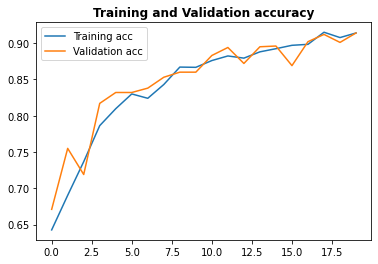

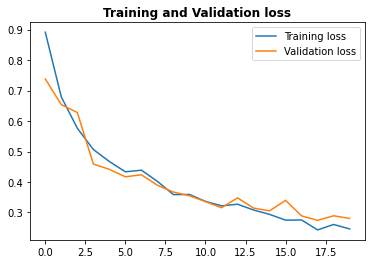

In [115]:
model_results(cnn_model_7, train_images, train_y, test_images, test_y)

32/32 [==============================] - 3s 105ms/step - loss: 0.2956 - accuracy: 0.9000


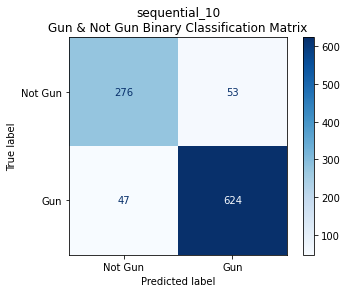

In [116]:
get_test_results(cnn_model_7, test_images, test_y)

Accuracy increrase to 90%, and precision score reduces to 93%. However, it doesnt seem to overfit as model 3 or 6. I would think it's the best performing model. 